
# **Taller 2 - CDA**

**Nombre: Juan Sebastián Peláez y Nicolás Tibatá**

# Enunciado.

ACTIVIDADES Y ENTREGABLES
1. [20%] Entendimiento y preparación de los datos: Genere un breve reporte de
entendimiento de datos en donde destaque las dimensiones del dataset, las
características de las imágenes e indicadores que considere importante. Integre técnicas
de aumento de datos y determine qué productos y que categorías empleará.
2. [20%] Entrenamiento del modelo de Machine Learning: Utilizando el conjunto de
imágenes, construya un modelo que sea capaz de predecir el tipo de producto. Pruebe al
menos dos modelos diferentes. Recuerde utilizar de la siguiente manera cada conjunto:
a. El conjunto de entrenamiento (train) para ajustar los hiperparámetros de los
modelos.
b. El conjunto de prueba (test) para seleccionar el mejor modelo.
c. El conjunto de validación (valid) para realizar el análisis de resultados del
modelo.
Aproxime su solución en el segundo nivel de categorías (Tipos de productos, i.e
manzanas, aguacates, bananas, etc).
3. [20%] Análisis de resultados del modelo: Calcule las métricas de evaluación para su
modelo, y explique su significado y su valor para la empresa. Justifique la calidad de su
modelo, qué elementos impactaron positivamente dichas métricas, y qué oportunidades
de mejora encuentra.
4. [20%] Generación de valor: y determine la ganancia esperada para el Supermercado
con la implementación del modelo por cada predicción acertada, así como el punto a
partir del cual la inversión en el modelo empezará a dejar dividendos. Realice una
estimación paramétrica, haciendo explícitos todos los supuestos usando datos,
incluyendo fuentes aplicables y estadísticas recientes. Para este punto debe considerar:
a. Los costos de tiempo asociado al registro de productos.
b. El ahorro de tiempo teórico de su modelo.
c. El costo asociado a los errores de su modelo.
d. El ahorro real por predicción acertada.
e. El ROI tomando en cuenta los costos de desarrollo y despliegue de su modelo.
5. [20%] Insights: Redacte un informe ejecutivo o una presentación corta en donde
muestre los hallazgos o insights más importantes en términos del modelo y los
resultados. Ofrezca una recomendación final para el negocio.
6. [10%] Bono: Realice su modelo usando el nivel detallado de tipos de productos y sus
marcas. (por ej. Manzanas Golden-Delicious, Granny-Smith, etc).

## **SE VA A RESOLVER CON REDES CONVOLUCIONALES**

# 0. Instalación de librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
!pip install kaggle --q

In [2]:
!pip install keras-tuner --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [3]:
#Numpy y Pandas
import pandas as pd
import numpy as np
from numpy import asarray
import requests
import cv2
from PIL import Image
from io import BytesIO

#Librerías de Scikit Learn
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#Librerías de Keras y Tensor Flow
import tensorflow as tf
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D, Activation, Reshape
from keras import backend as K
from keras import applications
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

#Gráficos
import matplotlib.pyplot as plt
%matplotlib inline

#Otras Librerías
import os.path as osp
from PIL import Image

#Verificamos las versiones de las librerías
print(f"La versión de sklearn es: {sklearn.__version__}")
print('Tensorflow version:', tf.__version__)

La versión de sklearn es: 1.5.2
Tensorflow version: 2.17.1


---
# 1. Entendimiento y preparación de los datos

Los parámetros de porcentaje de datos de prueba y la reproducibilidad:

In [ ]:
#random_state o semilla para la reproducibilidad
my_seed = 19

Definimos algunos parámetros, como el tamaño del batch y el tamaño de las imágenes a cargar.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

leemos los datos:

Leemos los datos para train de la carpeta de train

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
 "./data/train",
  label_mode='categorical',
  seed=my_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2407 files belonging to 36 classes.


Leemos los datos para validación de la carpeta de val:

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/val",
    label_mode='categorical',
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 291 files belonging to 36 classes.


Leemos los datos para test de la carpeta de test_

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "./data/test",
    label_mode='categorical',
    seed=my_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2266 files belonging to 36 classes.


Verificamos los nombres de las clases en los datos:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Cabbage', 'Carrots', 'Cucumber', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Soyghurt', 'Tomato', 'Yoghurt', 'Zucchini']


Podemos ver que tenemos 36 clases, lo cuál nos da una alta cardinalidad de los datos. Tenemos muchas categorías para clasificar. Estas son las categorías que vamos a utilizar: Apple, Asparagus, Aubergine, Avocado, Banana, Cabbage, Carrots, Cucumber, Ginger, Juice, Kiwi, Leek, Lemon, Lime, Mango, Melon, Milk, Oat-Milk, Oatghurt, Onion, Orange, Passion-Fruit, Peach, Pear, Pepper, Pineapple, Pomegranate, Potato, Red-Beet, Red-Grapefruit, Satsumas, Sour-Cream, Soyghurt, Tomato, Yoghurt y Zucchini.

Ahora vamos a verificar los tamaños de las imágenes:

In [ ]:
print("----------ENTRENAMIENTO----------")
for images, labels in train_ds.take(1):
    print("Núm. Imágenes:", images.shape)
    print("Clases:", labels.shape)


print("----------VALIDACIÓN----------")
for images, labels in val_ds.take(1):
    print("Núm. Imágenes:", images.shape)
    print("Clases:", labels.shape)


----------ENTRENAMIENTO----------
Núm. Imágenes: (32, 256, 256, 3)
Clases: (32, 36)
----------VALIDACIÓN----------
Núm. Imágenes: (32, 256, 256, 3)
Clases: (32, 36)


**Exploración de los datos.**

Vamos a visualizar una muestra:

In [ ]:
sample_train_ds = train_ds.shuffle(buffer_size=10, seed=my_seed)
sample_train_ds = sample_train_ds.take(1)

In [ ]:
sample_train_img = []
sample_train_lbl = []
for images, labels in sample_train_ds.take(1):
  for i in range(9):
    sample_train_img.append(images[i].numpy())
    sample_train_lbl.append(class_names[labels[i].numpy().argmax()])

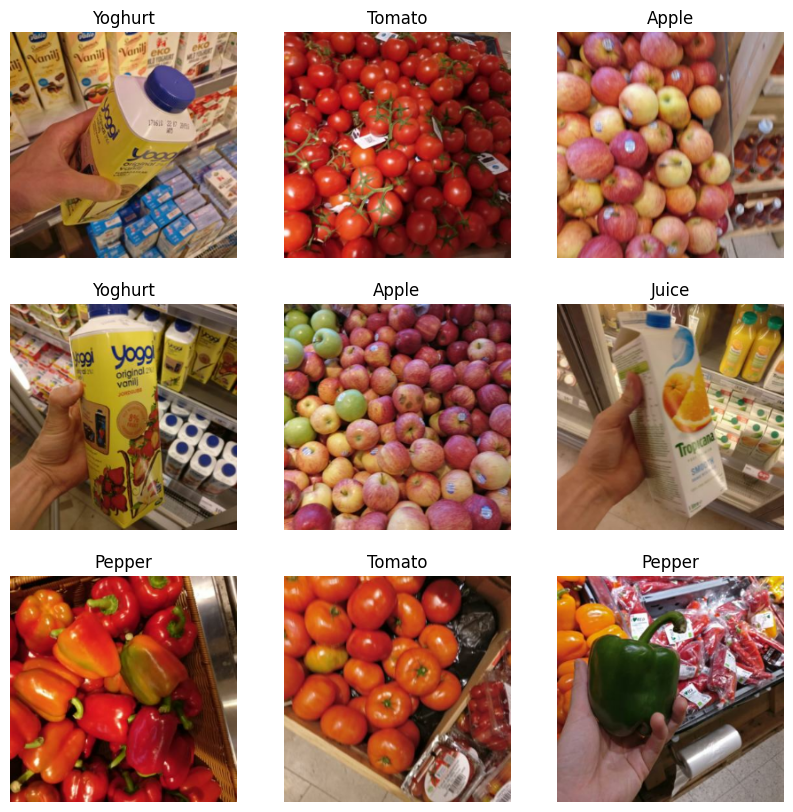

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(sample_train_img[i].astype("uint8"))
  plt.title(sample_train_lbl[i])
  plt.axis("off")

plt.show()

81
43


<Axes: xlabel='Coarse Class Name (str)'>

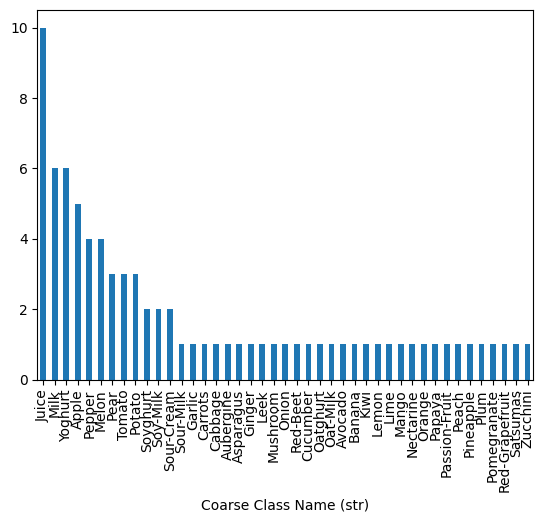

In [4]:
url = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/classes.csv"
df = pd.read_csv(url)

print(df['Class Name (str)'].nunique())
print(df['Coarse Class Name (str)'].nunique())

df['Coarse Class Name (str)'].value_counts().plot(kind='bar')

En terminos de labels encontramos que:
1. Tenemos 81 tipos de productos diferentes de manera segmentada.
2. De manera agrupada por clase de producto encontramos 43 diferentes, en donde encontramos como 'Juice' con el que mas productos agrupados tiene (10), seguido de 'Milk', 'Yogurt', 'Apple', etc... Esto significa que estos agrupados tienen una mayor variedad de productos dentro del supermercado.

In [5]:
df_train = pd.read_csv("https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/train.txt", names = ['path', 'name', 'coarse'])
df_val = pd.read_csv("https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/val.txt", names = ['path', 'name', 'coarse'])
df_test = pd.read_csv("https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/test.txt", names = ['path', 'name', 'coarse'])

# Función para imprimir información del dataset
def print_dataset_info(df, dataset_name):
    print(f"\nInformación para {dataset_name}:")
    print(f"Cantidad de filas: {len(df)}")
    print(f"Valores únicos de 'name': {df['name'].nunique()}")
    print(f"Valores únicos de 'coarse': {df['coarse'].nunique()}")

# Imprimir la información de cada dataset
print_dataset_info(df_train, "df_train")
print_dataset_info(df_val, "df_val")
print_dataset_info(df_test, "df_test")


Información para df_train:
Cantidad de filas: 2640
Valores únicos de 'name': 81
Valores únicos de 'coarse': 43

Información para df_val:
Cantidad de filas: 296
Valores únicos de 'name': 60
Valores únicos de 'coarse': 37

Información para df_test:
Cantidad de filas: 2485
Valores únicos de 'name': 81
Valores únicos de 'coarse': 43


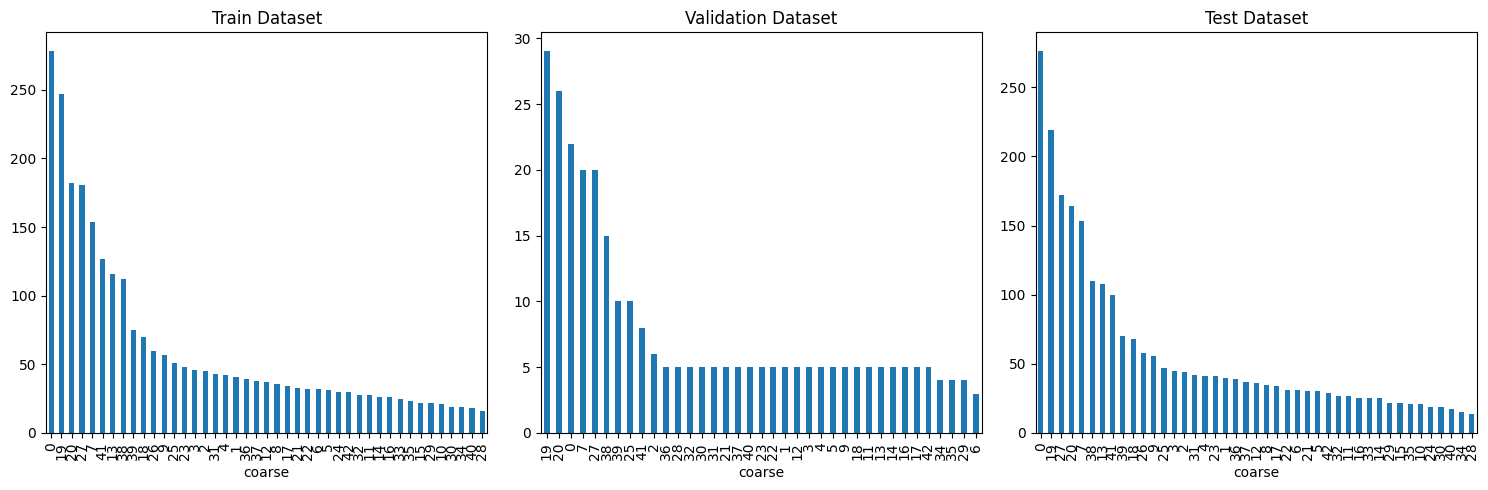

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de barras para df_train
df_train['coarse'].value_counts().plot(kind='bar', ax=ax[0], title="Train Dataset")

# Gráfico de barras para df_val
df_val['coarse'].value_counts().plot(kind='bar', ax=ax[1], title="Validation Dataset")

# Gráfico de barras para df_test
df_test['coarse'].value_counts().plot(kind='bar', ax=ax[2], title="Test Dataset")

# Ajustar el layout para que no se superpongan los títulos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

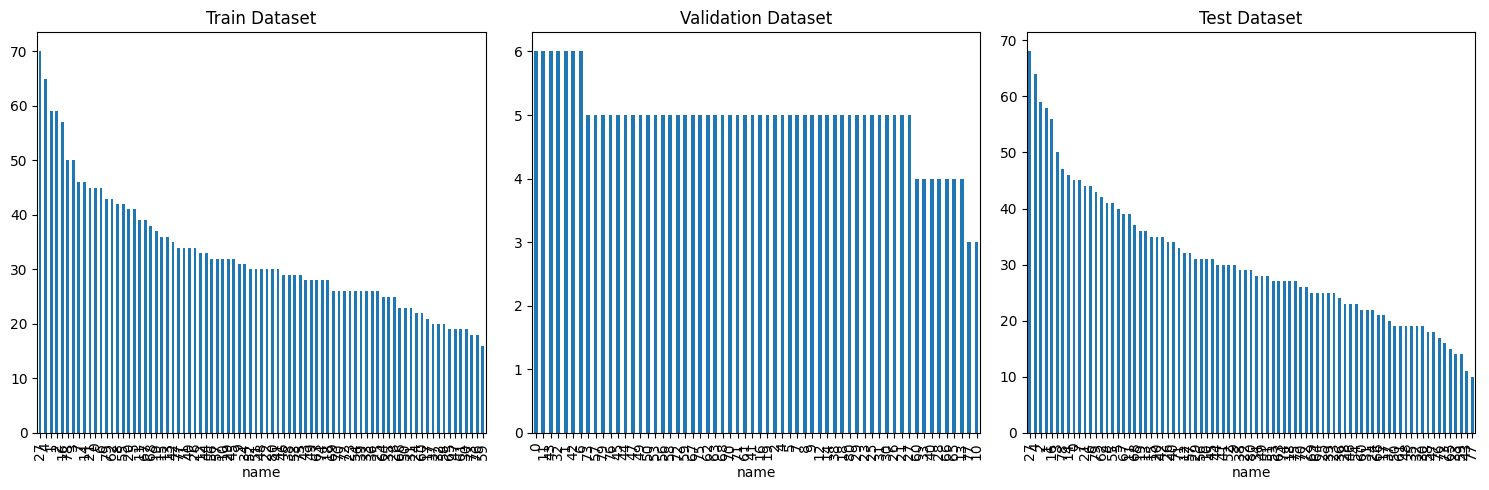

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de barras para df_train
df_train['name'].value_counts().plot(kind='bar', ax=ax[0], title="Train Dataset")

# Gráfico de barras para df_val
df_val['name'].value_counts().plot(kind='bar', ax=ax[1], title="Validation Dataset")

# Gráfico de barras para df_test
df_test['name'].value_counts().plot(kind='bar', ax=ax[2], title="Test Dataset")

# Ajustar el layout para que no se superpongan los títulos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

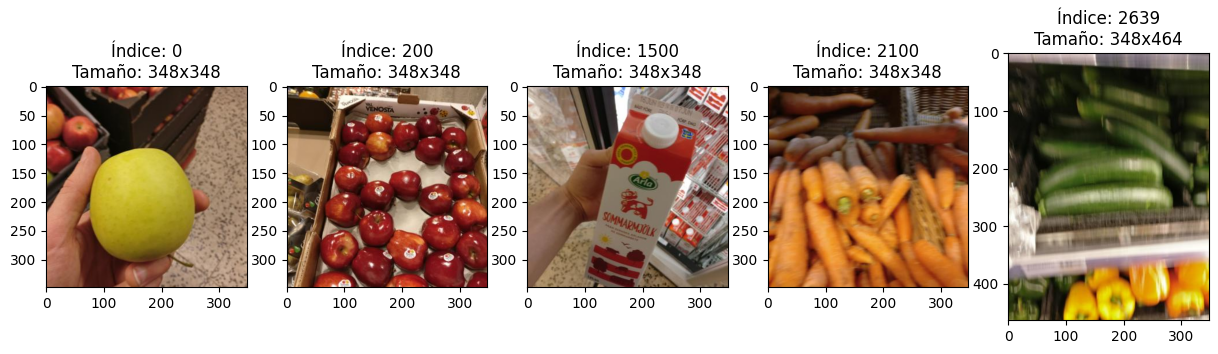

In [8]:
image_path = []
for path in df_train['path']:
  s = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/" + path
  image_path.append(s)

index = [0, 200, 1500, 2100, 2639]
fig, ax = plt.subplots(1, len(index), figsize=(15, 5))

for i, idx in enumerate(index):
  response = requests.get(image_path[idx])
  img = Image.open(BytesIO(response.content))

  width, height = img.size

  ax[i].imshow(img)
  ax[i].set_title(f"Índice: {idx}\nTamaño: {width}x{height}")

Dentro de la exploraciôn de los datos encontramos un total de 5421 imagenes, todas a color y con tamaños variables (el tamaño que predomina es 348 x 348). Además dentro del conjunto de validación no contamos con el total de labels segmentandos ni los agrupados, pero tanto en train como en validación si se encuentran completos. Además vemos que las imágenes dentro de cada dataset está desbalanceado, es decir no tenemos la misma cantidad de imágenes por cada label diferente, tanto a nivel segmentando (name) como a nivel agrupado (coarse). Dentro del modelamiento usaremos la variable 'coarse' ya que tiene menos variabilidad y nos asegura mejores resultados en nuestros modelos resultantes.

---
# 2.Entrenamiento del modelo de Machine Learning

## Modelo 1: Vamos a hacer una red convolucional.

In [ ]:
model = Sequential(name="Mi_primer_RNC")

Capas de **Preparación de Datos**

In [ ]:
model.add(Input(shape=(img_height, img_width, 3), batch_size=None, name='Capa_Entrada'))
model.add(Rescaling(1./255, name='Capa_Reescalado'))

model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Capas de **Entrenamiento**

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(256, (3, 3), activation='relu', name='Capa_Convolucional_3'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 370,816 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Capas de **Entrenamiento** Fully Connected

In [ ]:
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(128,activation='relu',name='Capa_Densa_1'))
model.add(Dense(64,activation='relu',name='Capa_Densa_2'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,344,000 (451.45 MB)

 Trainable params: 118,344,000 (451.45 MB)

 Non-trainable params: 0 (0.00 B)

Capa de **Salida**

In [ ]:
model.add(Dense(len(class_names), activation='softmax', name='Capa_Respuesta'))
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Respuesta (Dense)               │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,346,340 (451.46 MB)

 Trainable params: 118,346,340 (451.46 MB)

 Non-trainable params: 0 (0.00 B)

Ya con nuestra arquitectura construida, compilamos nuestro modelo definiendo que función de pérdida, optimizador y métrica vamos a utilizar para construir nuestro modelo.

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "Mi_primer_RNC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Capa_Reescalado (Rescaling)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_1 (Conv2D)        │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_2 (Conv2D)        │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Avg_Pool_1 (AveragePooling2D)        │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Convolucional_3 (Conv2D)        │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_1 (Dense)                 │ (None, 128)                 │     117,964,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Densa_2 (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Capa_Respuesta (Dense)               │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,346,340 (451.46 MB)

 Trainable params: 118,346,340 (451.46 MB)

 Non-trainable params: 0 (0.00 B)

Una manera más amigable de verlo...

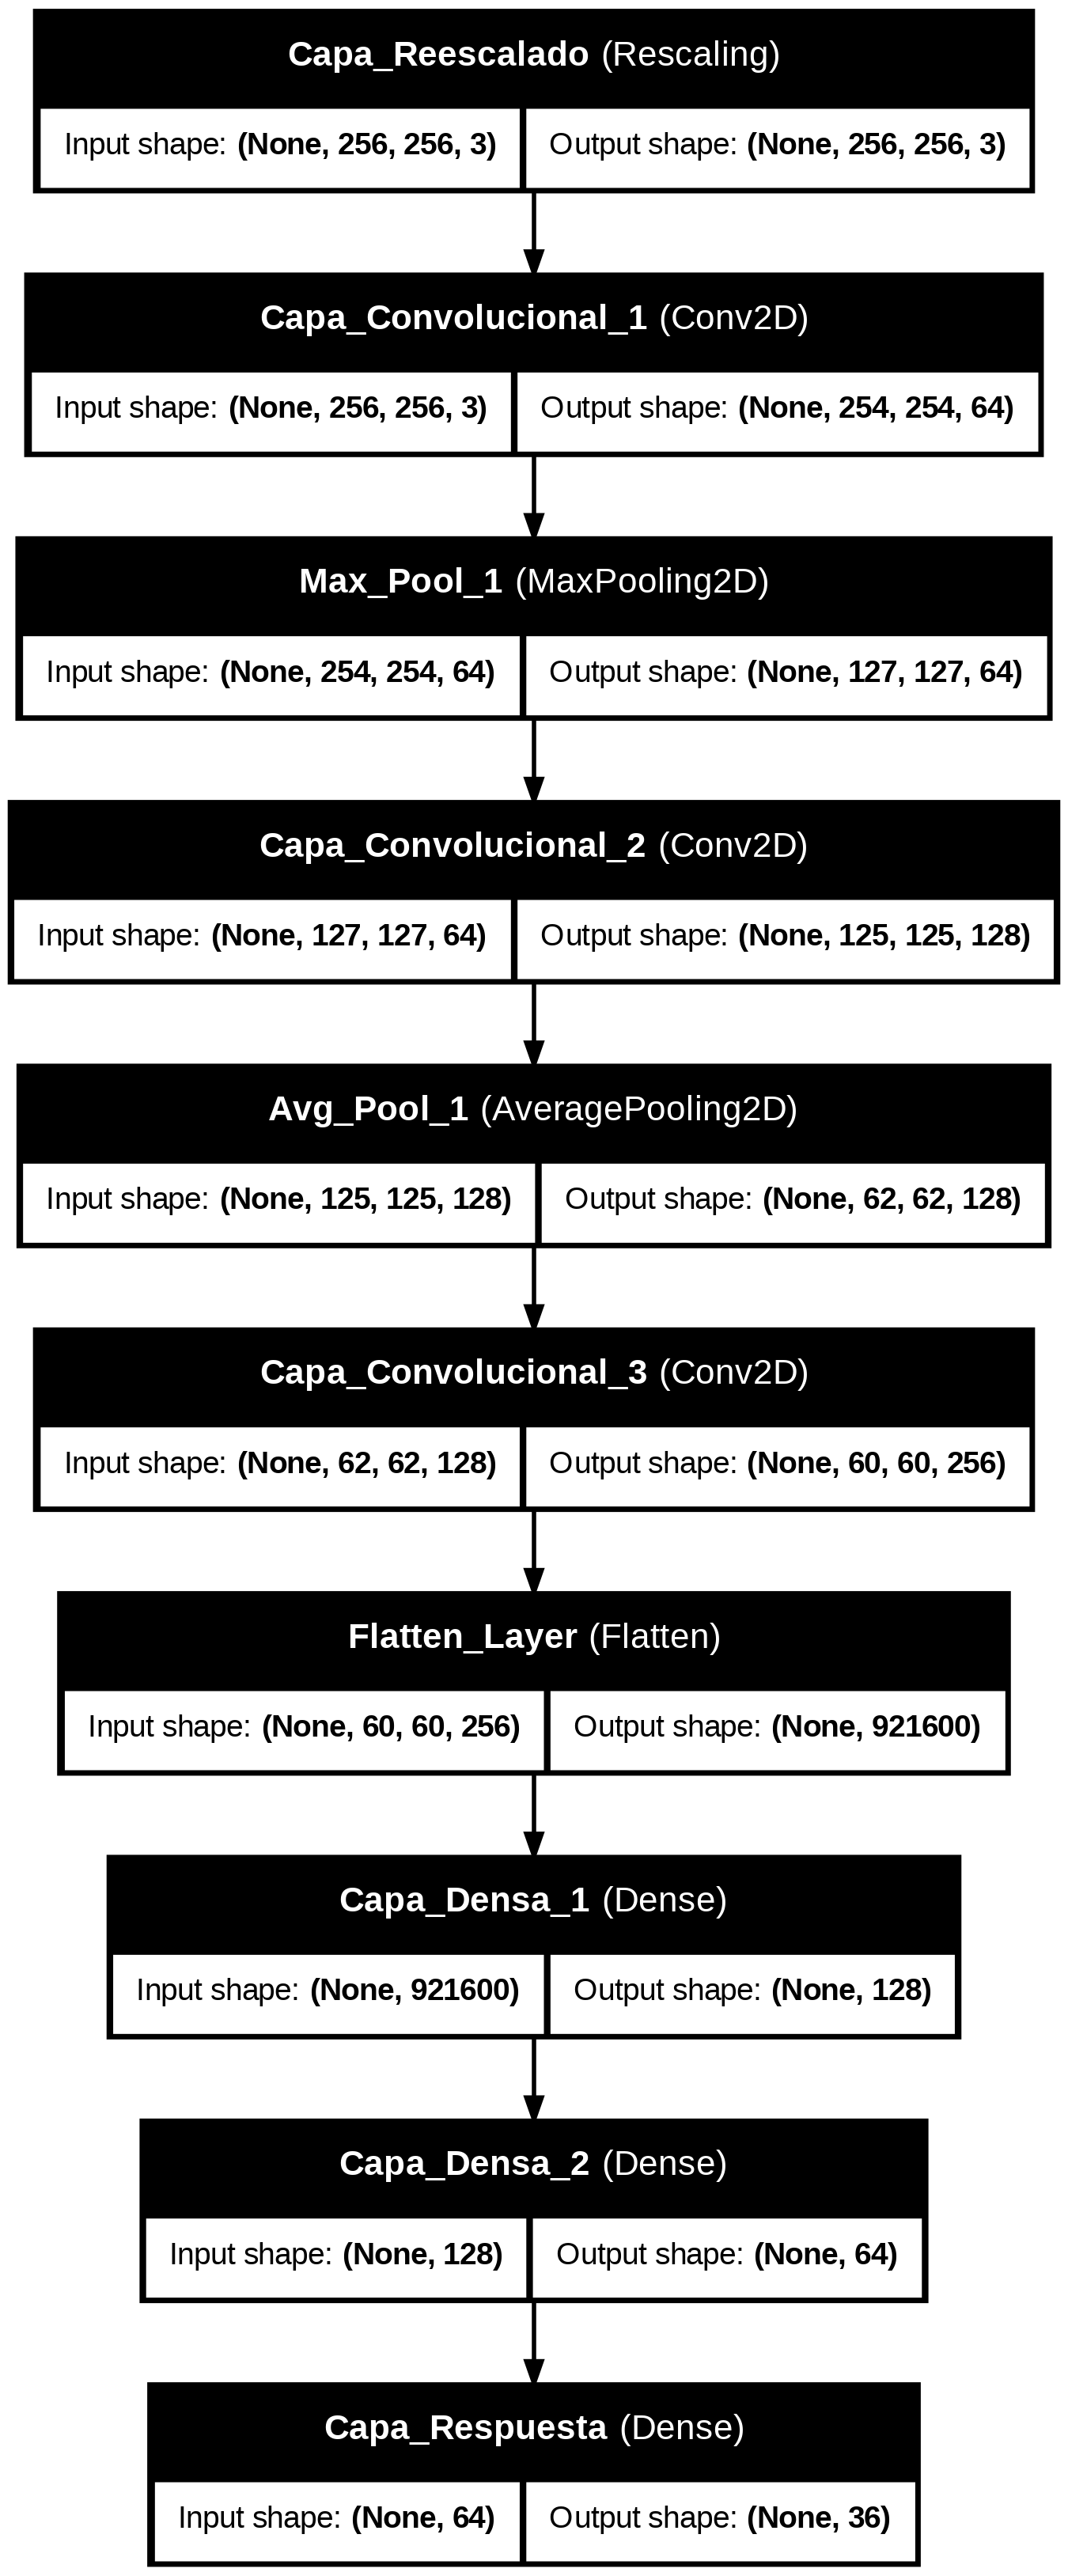

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

En el caso que el entrenamiento no mejore, podemos definir una función de parada temprada mediante un EarlyStopping, allí definimos el parámetro de la paciencia y podemos especificar el número de épocas que esperaremos. La parada temprana irá en el callback de la siguiente forma:

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Ya con nuestro modelo construido y compilado. Ahora sí podemos pasar a entrenarlo.

In [ ]:
#with tf.device(gpu_name):
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          callbacks=my_callbacks
  )

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 850s 11s/step - loss: 4.9391 - precision: 0.2319 - recall: 0.0209 - val_loss: 2.9464 - val_precision: 0.3200 - val_recall: 0.0275
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - loss: 2.3387 - precision: 0.5202 - recall: 0.0972 - val_loss: 2.7075 - val_precision: 0.3953 - val_recall: 0.0584
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - loss: 1.6532 - precision: 0.7519 - recall: 0.3093 - val_loss: 2.7228 - val_precision: 0.3939 - val_recall: 0.1340
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 1.1168 - precision: 0.8047 - recall: 0.5159 - val_loss: 2.9688 - val_precision: 0.3375 - val_recall: 0.1856
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - loss: 0.6216 - precision: 0.8680 - recall: 0.7323 - val_loss: 4.2202 - val_precision: 0.2967 - val_recall: 0.2131


**Predicción train.**

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

Y utilizaremos nuestro Reporte de Clasificación para poder interpretar los resultados del modelo.

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                precision    recall  f1-score   support

         Apple       0.81      0.97      0.88       278
     Asparagus       0.93      0.88      0.90        16
     Aubergine       1.00      1.00      1.00        22
       Avocado       0.95      0.95      0.95        41
        Banana       0.83      0.64      0.72        45
       Cabbage       1.00      0.95      0.97        19
       Carrots       0.92      0.53      0.68        43
      Cucumber       0.93      0.96      0.95        28
        Ginger       0.73      0.42      0.53        19
         Juice       0.99      0.94      0.96       247
          Kiwi       0.52      0.98      0.68        46
          Leek       0.96      0.96      0.96        23
         Lemon       0.86      0.43      0.57        42
          Lime       1.00      0.87      0.93        31
         Mango       0.53      0.97      0.68        32
         Melon       0.88      0.90      0.89       154
          Milk       1.00      0.88      0.94  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


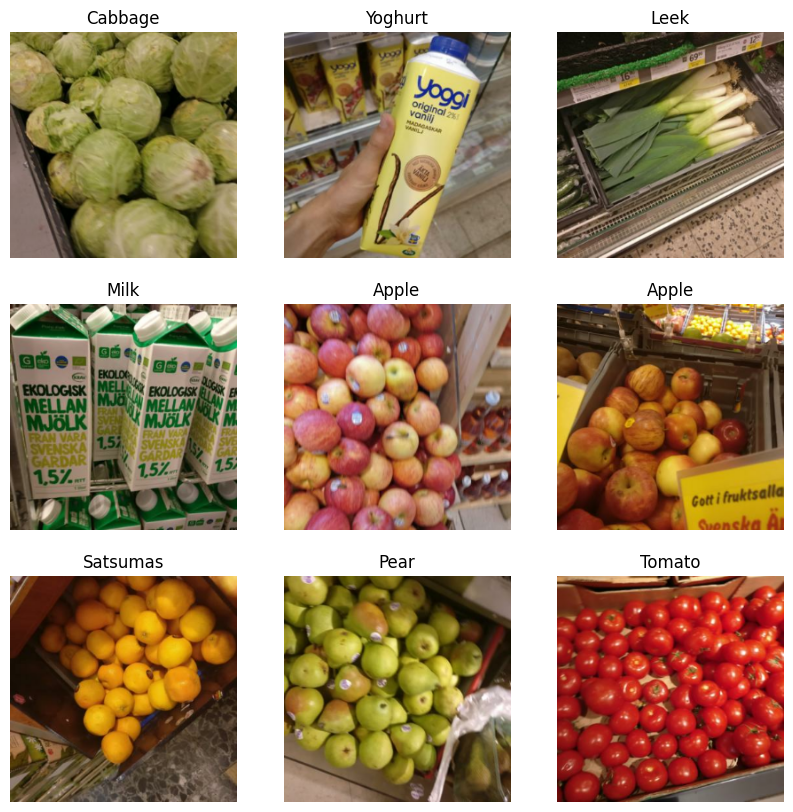

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

Pidemos ver que sobre entrenamiento se tiene un buen rendimiento con un 85% de precisión.

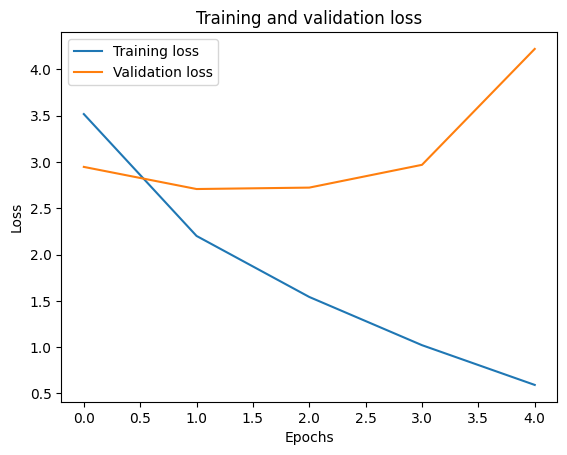

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Validación.**

Ahora vamos a probar el modelo sobre el conjunto de validación.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

                precision    recall  f1-score   support

         Apple       0.48      0.45      0.47        22
     Asparagus       0.00      0.00      0.00         5
     Aubergine       0.00      0.00      0.00         4
       Avocado       0.00      0.00      0.00         5
        Banana       0.00      0.00      0.00         6
       Cabbage       0.40      0.40      0.40         5
       Carrots       0.00      0.00      0.00         5
      Cucumber       0.71      1.00      0.83         5
        Ginger       0.00      0.00      0.00         4
         Juice       0.45      0.17      0.25        29
          Kiwi       0.06      0.20      0.09         5
          Leek       0.38      0.75      0.50         4
         Lemon       0.25      0.20      0.22         5
          Lime       0.50      0.60      0.55         5
         Mango       0.00      0.00      0.00         3
         Melon       0.17      0.30      0.21        20
          Milk       0.33      0.15      0.21  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Veamos la predicción aplicada en las imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


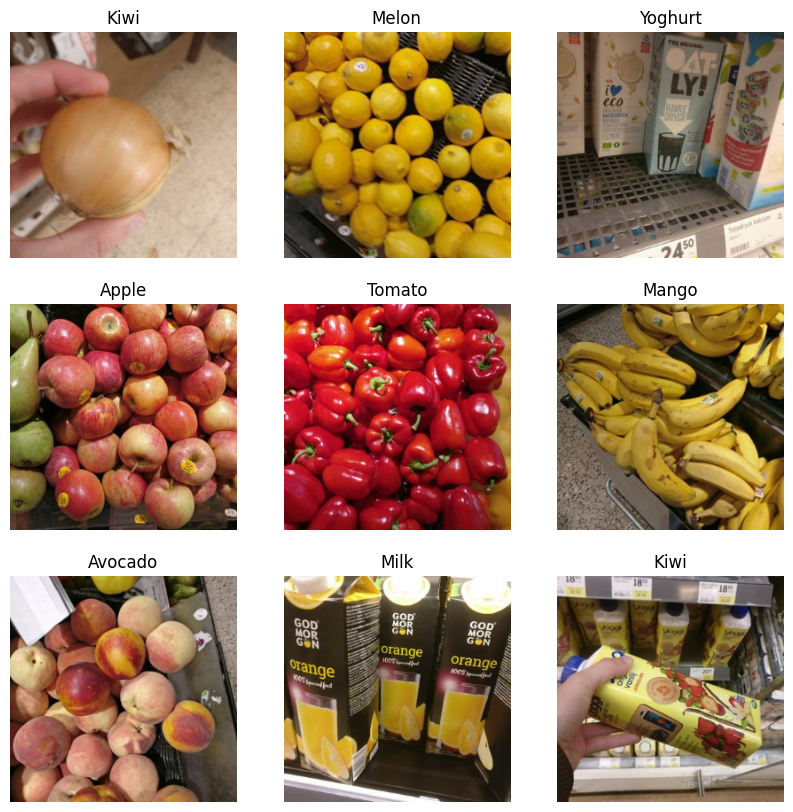

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

Para validación vemos que la precisión cae a un 23%

**Test**

In [ ]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [ ]:
print(classification_report(y_true, y_pred, target_names=list(class_names)))

                precision    recall  f1-score   support

         Apple       0.48      0.63      0.55       276
     Asparagus       0.00      0.00      0.00        14
     Aubergine       0.47      0.32      0.38        22
       Avocado       0.09      0.07      0.08        40
        Banana       0.17      0.05      0.07        44
       Cabbage       0.43      0.16      0.23        19
       Carrots       0.69      0.21      0.33        42
      Cucumber       0.38      0.37      0.38        27
        Ginger       0.00      0.00      0.00        15
         Juice       0.78      0.40      0.53       219
          Kiwi       0.14      0.31      0.19        45
          Leek       0.22      0.29      0.25        21
         Lemon       0.24      0.12      0.16        41
          Lime       0.59      0.33      0.43        30
         Mango       0.06      0.13      0.08        31
         Melon       0.23      0.31      0.27       153
          Milk       0.77      0.50      0.61  

In [ ]:
modelo_1 = classification_report(y_true, y_pred, target_names=list(class_names), output_dict=True)
df_modelo_1 = pd.DataFrame(modelo_1).transpose()
df_modelo_1

precision    recall  f1-score  support
Apple            0.483333  0.630435  0.547170    276.0
Asparagus        0.000000  0.000000  0.000000     14.0
Aubergine        0.466667  0.318182  0.378378     22.0
Avocado          0.093750  0.075000  0.083333     40.0
Banana           0.166667  0.045455  0.071429     44.0
Cabbage          0.428571  0.157895  0.230769     19.0
Carrots          0.692308  0.214286  0.327273     42.0
Cucumber         0.384615  0.370370  0.377358     27.0
Ginger           0.000000  0.000000  0.000000     15.0
Juice            0.783784  0.397260  0.527273    219.0
Kiwi             0.137255  0.311111  0.190476     45.0
Leek             0.222222  0.285714  0.250000     21.0
Lemon            0.238095  0.121951  0.161290     41.0
Lime             0.588235  0.333333  0.425532     30.0
Mango            0.059701  0.129032  0.081633     31.0
Melon            0.233831  0.307190  0.265537    153.0
Milk             0.773585  0.500000  0.607407    164.0
Oat-Milk         0.240964  0.645161  0.350877     31.0
Oatghurt         0.000000  0.000000  0.000000     30.0
Onion            0.076923  0.054054  0.063492     37.0
Orange           0.265487  0.535714  0.355030     56.0
Passion-Fruit    0.045455  0.037037  0.040816     27.0
Peach            0.166667  0.222222  0.190476     36.0
Pear             0.274194  0.157407  0.200000    108.0
Pepper           0.444444  0.109091  0.175182    110.0
Pineapple        0.291667  0.280000  0.285714     25.0
Pomegranate      0.051282  0.080000  0.062500     25.0
Potato           0.457627  0.385714  0.418605     70.0
Red-Beet         0.190476  0.470588  0.271186     17.0
Red-Grapefruit   0.000000  0.000000  0.000000     34.0
Satsumas         0.214286  0.044118  0.073171     68.0
Sour-Cream       0.666667  0.439024  0.529412     41.0
Soyghurt         0.551724  0.340426  0.421053     47.0
Tomato           0.653846  0.850000  0.739130    100.0
Yoghurt          0.420904  0.866279  0.566540    172.0
Zucchini         0.181818  0.137931  0.156863     29.0
micro avg        0.384819  0.384819  0.384819   2266.0
macro avg        0.304085  0.273666  0.261803   2266.0
weighted avg     0.415886  0.384819  0.367395   2266.0
samples avg      0.384819  0.384819  0.384819   2266.0

Visualizamos unas predicciones:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


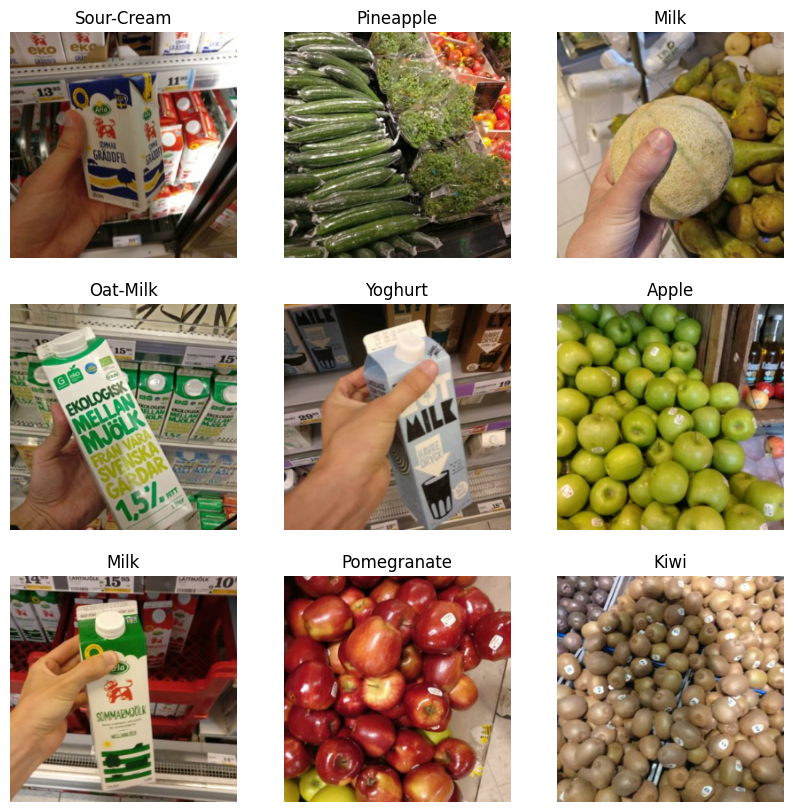

In [ ]:
plt.figure(figsize=(10, 10))

df = test_ds.take(1)
for images, labels in df:
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

Para test también tenemos una precisión baja con 37%

## Modelo 2: Red convolucional con búsqueda de hiperparametros:

Realizaremos una búsqueda de Hiperparámetros con RandomizedSearchCV para una red CNN:

In [ ]:
def construirMejorModelo(hip):
  bModel = Sequential(name="Modelo_Simple")

  # Entrada
  bModel.add(Input(shape=(img_height, img_width, 3), name='Entrada'))

  # Reescalado
  bModel.add(Rescaling(1./255, name='Reescalado'))

  # Capas Convolucionales y de Pooling
  bModel.add(Conv2D(filters=hip.Int('conv_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hip.Choice('conv_kernel', values=[3, 5]),
                     activation='relu',
                     name='Convolucional_1'))

  bModel.add(MaxPooling2D((2, 2), name='MaxPooling_1'))

  bModel.add(Conv2D(filters=hip.Int('conv_filters_2', min_value=64, max_value=256, step=64),
                     kernel_size=hip.Choice('conv_kernel_2', values=[3, 5]),
                     activation='relu',
                     name='Convolucional_2'))

  bModel.add(MaxPooling2D((2, 2), name='MaxPooling_2'))

  # Capas Densas
  bModel.add(Flatten(name='Flatten'))
  bModel.add(Dense(units=hip.Int('dense_units', min_value=64, max_value=128, step=64),
                    activation='relu', name='Densa'))
  bModel.add(Dense(36, activation='softmax', name='Salida'))

  # Compilación del modelo
  bModel.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(),
                   metrics=["accuracy"])

  return bModel

**Busqueda de hiperparámetros:**

In [ ]:
tuner = kt.RandomSearch(
    construirMejorModelo,
    objective="val_accuracy",
    project_name="cls_alimentos",
    seed=my_seed,
    max_trials=10)

In [ ]:
tuner.search(train_ds, validation_data=val_ds, callbacks=my_callbacks, epochs=30)

Trial 10 Complete [00h 00m 35s]

Best val_accuracy So Far: 0.3505154550075531
Total elapsed time: 00h 16m 26s


Almacenamos el mejor modelo en una variable:

In [ ]:
best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Y realizamos la descarga de nuestro modelo, junto con la vizualización de la arquitectura escogida por la búsqueda Aleatoria.

In [ ]:
best_model.save('best_model_cls_alimentos.h5')
best_model.summary()

Model: "Modelo_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Reescalado (Rescaling)               │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolucional_1 (Conv2D)             │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling_1 (MaxPooling2D)          │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Convolucional_2 (Conv2D)             │ (None, 125, 125, 256)       │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling_2 (MaxPooling2D)          │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 984064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Densa (Dense)                        │ (None, 128)                 │     125,960,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Salida (Dense)                       │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,114,468 (481.09 MB)

 Trainable params: 126,114,468 (481.09 MB)

 Non-trainable params: 0 (0.00 B)

Realizamos los mismos pasos que hicimos con nuestro modelo base, para poder comparar

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

**Train**

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                precision    recall  f1-score   support

         Apple       1.00      1.00      1.00       278
     Asparagus       1.00      1.00      1.00        16
     Aubergine       1.00      1.00      1.00        22
       Avocado       1.00      1.00      1.00        41
        Banana       0.98      1.00      0.99        45
       Cabbage       1.00      1.00      1.00        19
       Carrots       1.00      0.91      0.95        43
      Cucumber       1.00      1.00      1.00        28
        Ginger       1.00      1.00      1.00        19
         Juice       1.00      1.00      1.00       247
          Kiwi       1.00      1.00      1.00        46
          Leek       1.00      1.00      1.00        23
         Lemon       1.00      0.95      0.98        42
          Lime       1.00      1.00      1.00        31
         Mango       1.00      1.00      1.00        32
         Melon       0.99      0.99      0.99       154
          Milk       0.99      1.00      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Veamos la predicción con imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


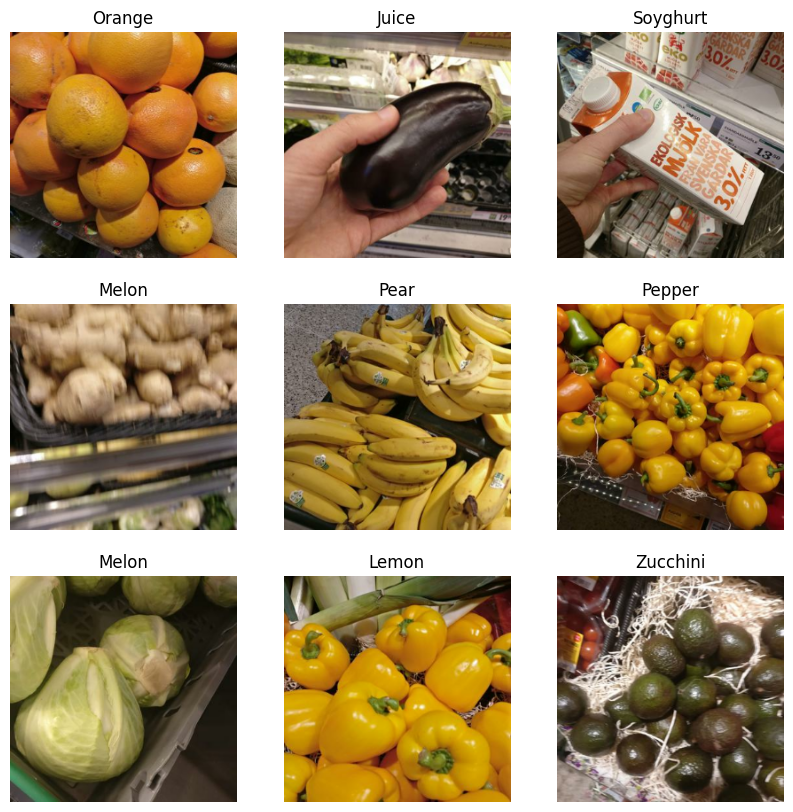

In [ ]:
plt.figure(figsize=(10, 10))

df = val_ds.take(1)
for images, labels in df:
  pred = best_model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(pred[i]).numpy()])
    plt.axis("off")

Nos da una precisión mucho más alta que el modelo anterior para entrenmiento, con 96% de precisión.

**Test**

In [ ]:
y_true = list()
y_pred = list()

for images, labels in test_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] > 0.5).astype(int))  # Convertir a 1 si la probabilidad es mayor a 0.5, 0 en caso contrario

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

Veamos el rendimiento con los datos de prueba:

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                precision    recall  f1-score   support

         Apple       0.58      0.71      0.64       276
     Asparagus       0.00      0.00      0.00        14
     Aubergine       0.88      0.32      0.47        22
       Avocado       0.11      0.12      0.12        40
        Banana       0.29      0.18      0.22        44
       Cabbage       0.00      0.00      0.00        19
       Carrots       0.67      0.10      0.17        42
      Cucumber       0.50      0.07      0.13        27
        Ginger       0.00      0.00      0.00        15
         Juice       0.61      0.60      0.61       219
          Kiwi       0.53      0.18      0.27        45
          Leek       0.15      0.14      0.15        21
         Lemon       0.67      0.10      0.17        41
          Lime       0.44      0.13      0.21        30
         Mango       0.27      0.23      0.25        31
         Melon       0.26      0.19      0.22       153
          Milk       0.75      0.83      0.79  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


El rendimniento en test es de un 47% de precisión. Es decir que nuestra diferencia es significativa y hay **overfitting** en el modelo, por lo tanto relizaremos otro modelo con Data Augmentation.

In [ ]:
modelo_2 = classification_report(y_true, y_pred, target_names=list(class_names), output_dict=True)
df_modelo_2 = pd.DataFrame(modelo_2).transpose()
df_modelo_2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score  support
Apple            0.582840  0.713768  0.641694    276.0
Asparagus        0.000000  0.000000  0.000000     14.0
Aubergine        0.875000  0.318182  0.466667     22.0
Avocado          0.108696  0.125000  0.116279     40.0
Banana           0.285714  0.181818  0.222222     44.0
Cabbage          0.000000  0.000000  0.000000     19.0
Carrots          0.666667  0.095238  0.166667     42.0
Cucumber         0.500000  0.074074  0.129032     27.0
Ginger           0.000000  0.000000  0.000000     15.0
Juice            0.608295  0.602740  0.605505    219.0
Kiwi             0.533333  0.177778  0.266667     45.0
Leek             0.150000  0.142857  0.146341     21.0
Lemon            0.666667  0.097561  0.170213     41.0
Lime             0.444444  0.133333  0.205128     30.0
Mango            0.269231  0.225806  0.245614     31.0
Melon            0.258929  0.189542  0.218868    153.0
Milk             0.747253  0.829268  0.786127    164.0
Oat-Milk         0.166667  0.032258  0.054054     31.0
Oatghurt         0.800000  0.133333  0.228571     30.0
Onion            0.156250  0.270270  0.198020     37.0
Orange           0.245614  0.250000  0.247788     56.0
Passion-Fruit    0.000000  0.000000  0.000000     27.0
Peach            0.363636  0.111111  0.170213     36.0
Pear             0.275862  0.222222  0.246154    108.0
Pepper           0.307143  0.390909  0.344000    110.0
Pineapple        0.400000  0.160000  0.228571     25.0
Pomegranate      0.285714  0.080000  0.125000     25.0
Potato           0.290323  0.128571  0.178218     70.0
Red-Beet         0.000000  0.000000  0.000000     17.0
Red-Grapefruit   0.000000  0.000000  0.000000     34.0
Satsumas         0.370370  0.294118  0.327869     68.0
Sour-Cream       0.535714  0.365854  0.434783     41.0
Soyghurt         0.493333  0.787234  0.606557     47.0
Tomato           0.735632  0.640000  0.684492    100.0
Yoghurt          0.592179  0.616279  0.603989    172.0
Zucchini         0.318182  0.241379  0.274510     29.0
micro avg        0.470527  0.401589  0.433333   2266.0
macro avg        0.362047  0.239736  0.259439   2266.0
weighted avg     0.453617  0.401589  0.403200   2266.0
samples avg      0.401589  0.401589  0.401589   2266.0

## Modelo 3: CNN + Data Augmentation sin Búsqueda de Hiperparámetros:

In [9]:
# Train data
image_path = []
for path in df_train['path']:
  s = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/" + path
  image_path.append(s)

def load_image_from_url(url):
    # Descargar la imagen
    response = requests.get(url)
    img_array = np.array(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)  # Leer la imagen en formato adecuado
    return img

image_ds = []
for image_url in image_path:
    img = load_image_from_url(image_url)
    if img is not None:
        resized = cv2.resize(img, (180, 180))
        image_ds.append(resized)

image_array = np.array(image_ds)
X_train = image_array / 255.0

In [10]:
X_train.shape

(2640, 180, 180, 3)

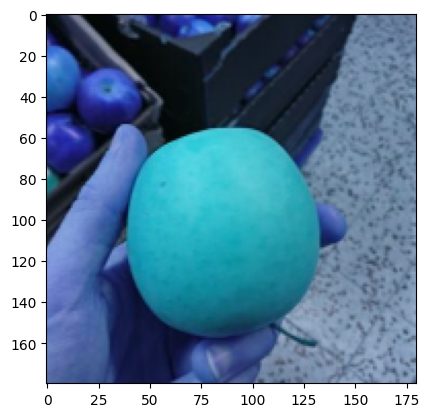

In [11]:
plt.imshow(X_train[0])

In [12]:
y_train = df_train['coarse']
y_train= np.array(y_train)
y_train

array([ 0,  0,  0, ..., 42, 42, 42])

In [13]:
# Test data
image_path_test = []
for path in df_test['path']:
  s = "https://raw.githubusercontent.com/marcusklasson/GroceryStoreDataset/refs/heads/master/dataset/" + path
  image_path_test.append(s)

def load_image_from_url(url):
    # Descargar la imagen
    response = requests.get(url)
    img_array = np.array(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)  # Leer la imagen en formato adecuado
    return img

image_ds_test = []
for image_url in image_path_test:
    img = load_image_from_url(image_url)
    if img is not None:
        resized = cv2.resize(img, (180, 180))
        image_ds_test.append(resized)

image_array = np.array(image_ds_test)
X_test = image_array / 255.0

In [14]:
X_test.shape

(2485, 180, 180, 3)

In [15]:
y_test = df_test['coarse']
y_test= np.array(y_test)
y_test

array([ 0,  0,  0, ..., 42, 42, 42])

**Data Augmentation**

In [16]:
data_augmentation = models.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(180,
                                  180,
                                  3)),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


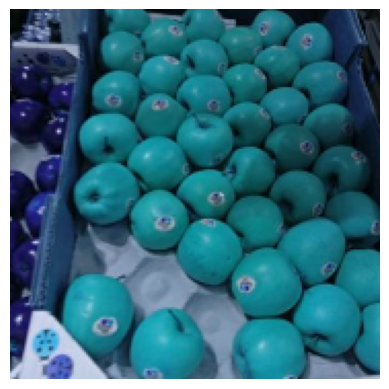

In [17]:
plt.axis('off')
plt.imshow(X_train[10])

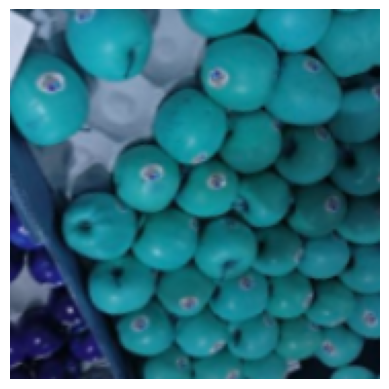

In [18]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[10])

In [19]:
modelDA = models.Sequential([

    data_augmentation,

    layers.Conv2D(filters = 86 , kernel_size = (3,3),activation = 'relu',input_shape= (180,180,3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters = 43 , kernel_size = (3,3),activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters = 43 , kernel_size = (3,3),activation = 'relu'),
    layers.MaxPool2D((2,2)),

    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(86,activation = 'relu'),
    #layers.Dense(43,activation = 'sigmoid'),
    layers.Dense(43,activation = 'softmax'),
    ])

modelDA.compile(
optimizer = 'adam',
    loss= 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
modelDA.fit(X_train,y_train , epochs = 60)

Epoch 1/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.1306 - loss: 3.3640
Epoch 2/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.2795 - loss: 2.5633
Epoch 3/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.3533 - loss: 2.1227
Epoch 4/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4287 - loss: 1.8249
Epoch 5/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.4858 - loss: 1.5544
Epoch 6/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.5138 - loss: 1.4654
Epoch 7/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5493 - loss: 1.3260
Epoch 8/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5899 - loss: 1.2223
Epoch 9/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.6081 - loss: 1.1949
Epoch 10/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.6290 - loss: 1.1214
Epoch 11/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.6415 - loss: 1.0536
Epoch 12/60
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 10

In [21]:
modelDA.evaluate(X_test, y_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6291 - loss: 1.4808


[1.5577247142791748, 0.6362172961235046]

In [22]:
# Obtener las predicciones
y_pred_probs = modelDA.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir a clases predichas

# Generar el reporte de clasificación
print(classification_report(y_train, y_pred))

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       278
           1       0.93      0.98      0.95        41
           2       0.83      0.76      0.79        45
           3       0.85      0.87      0.86        46
           4       0.97      0.86      0.91        42
           5       1.00      1.00      1.00        31
           6       0.97      0.94      0.95        32
           7       0.96      0.82      0.89       154
           8       0.92      1.00      0.96        36
           9       0.90      0.93      0.91        57
          10       0.79      0.90      0.84        21
          11       0.89      0.89      0.89        28
          12       1.00      0.97      0.99        37
          13       0.88      0.81      0.84       116
          14       0.93      0.96      0.94        26
          15       0.88      1.00      0.94        22
          16       0.94      0.65      0.

In [23]:
y_pred_probs = modelDA.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       276
           1       0.42      0.62      0.50        40
           2       0.44      0.16      0.23        44
           3       0.17      0.09      0.12        45
           4       0.59      0.32      0.41        41
           5       0.52      0.43      0.47        30
           6       0.13      0.10      0.11        31
           7       0.64      0.47      0.54       153
           8       0.60      0.86      0.71        35
           9       0.23      0.30      0.26        56
          10       0.26      0.52      0.34        21
          11       0.10      0.19      0.13        27
          12       0.56      0.28      0.37        36
          13       0.49      0.51      0.50       108
          14       0.48      0.60      0.54        25
          15       0.60      0.41      0.49        22
          16       0.29      0.08      0.

## **3. Análisis de resultados del modelo**

In [ ]:
df_modelo_1['modelo'] = 'Sin búsqueda de hiperparametros'
df_modelo_2['modelo'] = 'Con búsqueda de hiperparametros'

In [ ]:
df_comparison = pd.concat([df_modelo_1, df_modelo_2], axis = 1)
df_comparison

precision    recall  f1-score  support  \
Apple            0.483333  0.630435  0.547170    276.0   
Asparagus        0.000000  0.000000  0.000000     14.0   
Aubergine        0.466667  0.318182  0.378378     22.0   
Avocado          0.093750  0.075000  0.083333     40.0   
Banana           0.166667  0.045455  0.071429     44.0   
Cabbage          0.428571  0.157895  0.230769     19.0   
Carrots          0.692308  0.214286  0.327273     42.0   
Cucumber         0.384615  0.370370  0.377358     27.0   
Ginger           0.000000  0.000000  0.000000     15.0   
Juice            0.783784  0.397260  0.527273    219.0   
Kiwi             0.137255  0.311111  0.190476     45.0   
Leek             0.222222  0.285714  0.250000     21.0   
Lemon            0.238095  0.121951  0.161290     41.0   
Lime             0.588235  0.333333  0.425532     30.0   
Mango            0.059701  0.129032  0.081633     31.0   
Melon            0.233831  0.307190  0.265537    153.0   
Milk             0.773585  0.500000  0.607407    164.0   
Oat-Milk         0.240964  0.645161  0.350877     31.0   
Oatghurt         0.000000  0.000000  0.000000     30.0   
Onion            0.076923  0.054054  0.063492     37.0   
Orange           0.265487  0.535714  0.355030     56.0   
Passion-Fruit    0.045455  0.037037  0.040816     27.0   
Peach            0.166667  0.222222  0.190476     36.0   
Pear             0.274194  0.157407  0.200000    108.0   
Pepper           0.444444  0.109091  0.175182    110.0   
Pineapple        0.291667  0.280000  0.285714     25.0   
Pomegranate      0.051282  0.080000  0.062500     25.0   
Potato           0.457627  0.385714  0.418605     70.0   
Red-Beet         0.190476  0.470588  0.271186     17.0   
Red-Grapefruit   0.000000  0.000000  0.000000     34.0   
Satsumas         0.214286  0.044118  0.073171     68.0   
Sour-Cream       0.666667  0.439024  0.529412     41.0   
Soyghurt         0.551724  0.340426  0.421053     47.0   
Tomato           0.653846  0.850000  0.739130    100.0   
Yoghurt          0.420904  0.866279  0.566540    172.0   
Zucchini         0.181818  0.137931  0.156863     29.0   
micro avg        0.384819  0.384819  0.384819   2266.0   
macro avg        0.304085  0.273666  0.261803   2266.0   
weighted avg     0.415886  0.384819  0.367395   2266.0   
samples avg      0.384819  0.384819  0.384819   2266.0   

                                         modelo  precision    recall  \
Apple           Sin búsqueda de hiperparametros   0.582840  0.713768   
Asparagus       Sin búsqueda de hiperparametros   0.000000  0.000000   
Aubergine       Sin búsqueda de hiperparametros   0.875000  0.318182   
Avocado         Sin búsqueda de hiperparametros   0.108696  0.125000   
Banana          Sin búsqueda de hiperparametros   0.285714  0.181818   
Cabbage         Sin búsqueda de hiperparametros   0.000000  0.000000   
Carrots         Sin búsqueda de hiperparametros   0.666667  0.095238   
Cucumber        Sin búsqueda de hiperparametros   0.500000  0.074074   
Ginger          Sin búsqueda de hiperparametros   0.000000  0.000000   
Juice           Sin búsqueda de hiperparametros   0.608295  0.602740   
Kiwi            Sin búsqueda de hiperparametros   0.533333  0.177778   
Leek            Sin búsqueda de hiperparametros   0.150000  0.142857   
Lemon           Sin búsqueda de hiperparametros   0.666667  0.097561   
Lime            Sin búsqueda de hiperparametros   0.444444  0.133333   
Mango           Sin búsqueda de hiperparametros   0.269231  0.225806   
Melon           Sin búsqueda de hiperparametros   0.258929  0.189542   
Milk            Sin búsqueda de hiperparametros   0.747253  0.829268   
Oat-Milk        Sin búsqueda de hiperparametros   0.166667  0.032258   
Oatghurt        Sin búsqueda de hiperparametros   0.800000  0.133333   
Onion           Sin búsqueda de hiperparametros   0.156250  0.270270   
Orange          Sin búsqueda de hiperparametros   0.245614  0.250000   
Passion-Fruit   Sin búsqueda de hiperparametros   0.0

El análisis comparativo de los modelos muestra que el modelo 2 presenta un mejor desempeño en el conjunto de prueba, lo que indica una mayor capacidad de generalización. Al examinar las métricas, se observa que el modelo 1 logra un recall promedio del 38%, lo que significa que identifica correctamente el 38% de las imágenes en cada categoría de alimento. Por otro lado, el modelo 2 mejora este valor, alcanzando un recall promedio del 40%.



En cuanto a la precisión, el modelo 1 clasifica correctamente, en promedio, el 38% de las imágenes asignadas a cada clase, mientras que el modelo 2 incrementa esta métrica a un 47%, mostrando una mejora considerable. Esto demuestra que el modelo 2 no solo tiene una mejor capacidad para identificar correctamente las imágenes, sino que también lo hace con mayor exactitud en cada categoría analizada.


Sin embargo el modelo 3 tiene los mejores resultados, con una mejor precision (64%) y con menos indicios de sobreajuste. Pues aproximadamente el 64% de las imagenes clasifica de manera correcta e incluye la aumentación de los datos que permite una mejor generalización a datos externos del modelo.

Por último creemos que dentro de las oportunidades de mejora para el modelamiento es modelos con arquitecturas más exhaustivas que permitan tomar las características precisas de los productos, también uso de GPU para poder procesar las imágenes en su completa dimensionalidad, por último se puede considerar el uso de redes preentrenadas que permitan una mejor calidad de precision y además menos tiempo y recursos en el momento de entrenar.

## **4. Generación de valor**

Suposiciones:

1. Tiempo asociado al registro de producto: 4 min
2. Costo de tiempo asociado al registro del producto: 10 mil x hora
3. Tiempo que se ahorra con el modelo: 3 min
4. En 30 días hay 1.000 productos registrados
5. El salario de un cientifico de datos = 30.000 mil x hora


g = ahorros esperados - ((1 - precisión calculada promedio)*costo de arreglar un error manualmente)

In [24]:
a = 3
i = 0.64
e = 4

Ganancia por predicción:

In [25]:
g = a-((1-i)*e)
print(g)

1.56


Por producto, la ganancia es de 1.56 minutos, o aproximadamente 1560 minutos por 1.000 productos registrados al mes

En términos económicos:

In [26]:
g_mes = g*1000
g_mes_en_horas = g_mes/60
ahorro_modelo = 10.000*g_mes_en_horas
print(ahorro_modelo)

260.0


El modelo está ahorrando 260 mil pesos al mes

Si el modelo toma 2 semanas de trabajo:

In [27]:
s = 30.000*80
roi_cero = s/ahorro_modelo
print(roi_cero)

9.23076923076923


Este modelo tendrá un ROI de 0 luego de aproximadamente 9 meses